# Model from the Saranya paper

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import os

#NN
import keras
from keras import layers
from keras.models import Sequential

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from sklearn.preprocessing import OneHotEncoder

# setting seed 
np.random.seed(seed=42)

2023-06-03 11:51:45.395735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Images preview

In [2]:
i = 3
img_1 = cv2.imread(f"seg_dataset_saranya2021/Green/{str(i)}.jpg")
img_2 = cv2.imread("seg_dataset_saranya2021/Overripen/2.jpg")
print("image 1 shape (lines, columns, channels) = ", img_1.shape) 
print("image 2 shape (lines, columns, channels) = ", img_2.shape) 
print("\nimage type: ", type(img_1))

image 1 shape (lines, columns, channels) =  (536, 960, 3)
image 2 shape (lines, columns, channels) =  (536, 960, 3)

image type:  <class 'numpy.ndarray'>


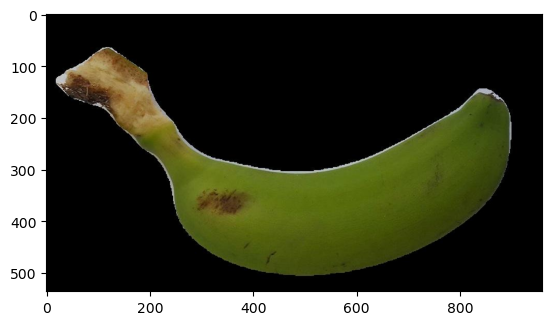

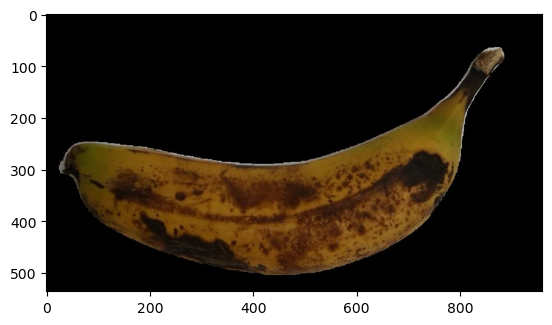

In [3]:
rgb_img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB) # BGR to RGB 
rgb_img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB) # BGR to RGB 
plt.imshow(rgb_img_1)
#plt.axis('off')
plt.show()

plt.imshow(rgb_img_2)
#plt.axis('off')
plt.show()

## Data Pre-processing

### dataset Saranya

In [4]:
# paths to the image folders of each class
class1_path = "seg_dataset_saranya2021/Green"
class2_path = "seg_dataset_saranya2021/Yellowish_Green"
class3_path = "seg_dataset_saranya2021/Midripen"
class4_path = "seg_dataset_saranya2021/Overripen"

# Define empty lists to store the images and labels
images = []
labels = []

# Loop through each folder and extract the images
for class_path, class_label in [(class1_path, 0), (class2_path, 1), (class3_path, 2), (class4_path, 3)]:
    for image_file in os.listdir(class_path):
        # Load the image and convert to RGB format
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (64, 64))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # Add the image and label to the lists
        images.append(image)
        labels.append(class_label)

# Convert the images and labels to NumPy arrays
X = np.array(images)
y = np.array(labels)

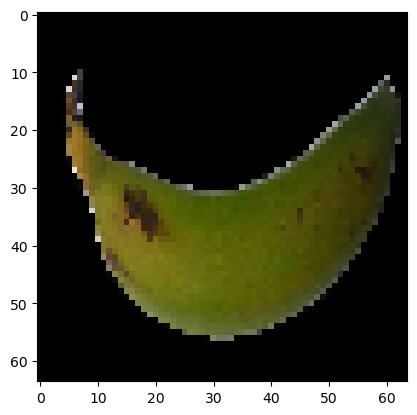

In [5]:
plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_HSV2RGB))
#plt.axis('off')
plt.show()

In [6]:
#from collections import Counter
#print(sorted(Counter(y).items()))

### Spliting the data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.4, 
                                                    shuffle= True,
                                                    random_state=42)


### Balancing data with weights

In [8]:
# takes a vector with labels y, 
# returns the proper class weights 
# to be used in the fit function from keras
# to use in the training of the model
# prints the no. of classes

# returned variable to be used in training keras model

def get_weights(yy):
    y=yy
    # no. of elements per class
    unique_classes, class_counts = np.unique(y, return_counts=True, axis=0)
    print(f"unique_classes-->{unique_classes}")
    # Print the unique classes and their corresponding counts
    for cls, count in zip(unique_classes, class_counts):
        print(f"Class {cls}: {count} instances")

    total_instances = np.sum(class_counts)
    class_weights = total_instances / (class_counts * len(unique_classes))

    # Print the class weights
    for cls, weight in zip(unique_classes, class_weights):
        print(f"Class {cls} weight: {weight}")

    class_weights /= np.sum(class_weights)

    # Print the normalized class weights
    for cls, weight in zip(unique_classes, class_weights):
        print(f"Class {cls} weight (normalized): {weight}")


    w_dict = {}
    for i in range(len(unique_classes)):
        w_dict[i] = class_weights[i]
    
    return w_dict

In [9]:
w = get_weights(y_train)
w

unique_classes-->[0 1 2 3]
Class 0: 63 instances
Class 1: 23 instances
Class 2: 54 instances
Class 3: 22 instances
Class 0 weight: 0.6428571428571429
Class 1 weight: 1.7608695652173914
Class 2 weight: 0.75
Class 3 weight: 1.8409090909090908
Class 0 weight (normalized): 0.1287095133118535
Class 1 weight (normalized): 0.3525521451585552
Class 2 weight (normalized): 0.15016109886382908
Class 3 weight (normalized): 0.36857724266576225


{0: 0.1287095133118535,
 1: 0.3525521451585552,
 2: 0.15016109886382908,
 3: 0.36857724266576225}

In [10]:
s = get_weights(y_test)

unique_classes-->[0 1 2 3]
Class 0: 40 instances
Class 1: 25 instances
Class 2: 33 instances
Class 3: 11 instances
Class 0 weight: 0.68125
Class 1 weight: 1.09
Class 2 weight: 0.8257575757575758
Class 3 weight: 2.477272727272727
Class 0 weight (normalized): 0.13425549227013833
Class 1 weight (normalized): 0.21480878763222133
Class 2 weight (normalized): 0.1627339300244101
Class 3 weight (normalized): 0.4882017900732302


## Data Augmentation

Only applying data augmentation to the training data so that the model is not being evaluated on artifiacilly generated data

In [11]:
def data_augmentation(X, y, num_augmented_samples = 100):
    augmented_X = []
    augmented_y = []

    # Obtain the number of original samples
    num_samples = X.shape[0]

    # Calculate the number of augmented samples needed for each class
    unique_classes, label_counts = np.unique(y, return_counts=True, axis=0)
    max_label_count = np.max(label_counts)
    num_augmented_per_class = (max_label_count - label_counts) + num_augmented_samples
    num_augmented_per_class = np.array(num_augmented_per_class, dtype=int)

    # while there are still classes to be augmented
    while np.any(num_augmented_per_class):

        ran = np.random.randint(num_samples)

        image = X[ran]
        label = y[ran]

        if num_augmented_per_class[label] > 0:

            flip = np.random.choice(['y', 'n'])

            angle = np.random.uniform(-90, 90)
            rotated_image = rotate_image(image, angle)

            tx = np.random.randint(-10, 10)
            ty = np.random.randint(-10, 10)
            translated_image = translate_image(rotated_image, tx, ty)

            brightness_factor = np.random.uniform(0.5, 1.3)
            augmented_image = adjust_brightness(translated_image, brightness_factor)

            if flip == 'y':
                augmented_image = flip_image(augmented_image, flip_code=1)

            #plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_HSV2RGB))
            #plt.show()

            augmented_X.append(augmented_image)
            augmented_y.append(label)

            num_augmented_per_class[label] -= 1
        
    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)

    return np.append(X, augmented_X, axis=0), np.append(y, augmented_y, axis=0)

def adjust_brightness(image, factor):
    image = image.astype(np.float32)
    image[:, :, 2] *= factor
    image[:, :, 2] = np.clip(image[:, :, 2], 0, 255)
    return image.astype(np.uint8)

def rotate_image(image, angle):
    height, width, _ = image.shape
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def flip_image(image, flip_code):
    flipped_image = cv2.flip(image, flip_code)
    return flipped_image

def translate_image(image, tx, ty):
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    translated_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    return translated_image


In [12]:
X_aug, y_aug = data_augmentation(X_train, y_train, 200)

In [13]:
get_weights(y_aug)

unique_classes-->[0 1 2 3]
Class 0: 263 instances
Class 1: 263 instances
Class 2: 263 instances
Class 3: 263 instances
Class 0 weight: 1.0
Class 1 weight: 1.0
Class 2 weight: 1.0
Class 3 weight: 1.0
Class 0 weight (normalized): 0.25
Class 1 weight (normalized): 0.25
Class 2 weight (normalized): 0.25
Class 3 weight (normalized): 0.25


{0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}

## Normalizing input data to improve training speed and OHE

In [14]:
hsv_max = [179, 255, 255]

X_aug_norm = np.divide(X_aug, hsv_max)
X_test_norm = np.divide(X_test, hsv_max)

from keras.utils import to_categorical

# Convert labels to one-hot encoding
y_aug_hot = to_categorical(y_aug)
y_test_hot = to_categorical(y_test)

## CNN

In [15]:
model = Sequential()

# layers.Conv2D(# of filters, filter dimension, ...)
# padding = 'valid' means no padding
model.add(layers.Conv2D(32, 3, activation = 'relu', padding="valid", input_shape = X[0].shape))
model.add(layers.Conv2D(16, 5, activation = 'relu', strides=(1, 1), padding="valid"))
model.add(layers.Conv2D(16, 5, activation = 'relu', padding="valid"))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, 3, activation = 'relu', padding="valid"))
model.add(layers.Conv2D(16, 5, activation = 'relu', padding="valid"))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(units = 16, activation = 'relu'))
model.add(layers.Dense(units = 4, activation = 'softmax'))

opt_1 = keras.optimizers.Adam(learning_rate=0.005)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

2023-06-03 11:51:59.439846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        12816     
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 54, 16)        6416      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 16)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 16)        2320      
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 16)        6416      
                                                        

callbacks, only using one

In [17]:
cb_early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

cb_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.9,
    patience=2,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=4,
    min_lr=1e-4,
)

In [18]:
bf = model.fit(X_aug_norm, y_aug_hot, validation_data=(X_test_norm, y_test_hot),# class_weight = w,
               epochs=50, batch_size=32, callbacks=[cb_early, cb_plateau])

Epoch 1/50
33/33 [==============================] - 12s 324ms/step - loss: 1.3884 - accuracy: 0.2462 - val_loss: 1.3581 - val_accuracy: 0.1743 - lr: 0.0010
Epoch 2/50
33/33 [==============================] - 10s 318ms/step - loss: 1.2155 - accuracy: 0.3546 - val_loss: 0.8639 - val_accuracy: 0.6697 - lr: 0.0010
Epoch 3/50
33/33 [==============================] - 14s 424ms/step - loss: 1.0277 - accuracy: 0.5010 - val_loss: 0.6499 - val_accuracy: 0.7431 - lr: 0.0010
Epoch 4/50
33/33 [==============================] - 12s 350ms/step - loss: 0.9074 - accuracy: 0.5466 - val_loss: 0.6200 - val_accuracy: 0.7248 - lr: 0.0010
Epoch 5/50
33/33 [==============================] - 10s 303ms/step - loss: 0.8179 - accuracy: 0.6065 - val_loss: 0.6564 - val_accuracy: 0.6881 - lr: 0.0010
Epoch 6/50
33/33 [==============================] - 15s 447ms/step - loss: 0.7826 - accuracy: 0.6397 - val_loss: 0.5977 - val_accuracy: 0.7339 - lr: 0.0010
Epoch 7/50
33/33 [==============================] - 14s 429ms/st

## Results

In [19]:
# best epoch obtained
results_test = model.evaluate(X_test_norm, y_test_hot)
print(results_test)

4/4 [==============================] - 0s 68ms/step - loss: 0.2375 - accuracy: 0.9083
[0.23750422894954681, 0.9082568883895874]


In [20]:
# summary of the model applied to the validation set
y_preds = model.predict(X_test_norm)

y_max = np.max(y_preds, axis=1)
y_p = np.zeros(y_preds.shape)

for i in range(y_p.shape[0]):
    y_p[i, (np.where(y_preds[i]==np.max(y_preds[i])))] = 1

#print(y_p)

print(metrics.classification_report(y_test_hot, y_p))

4/4 [==============================] - 1s 77ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.86      0.76      0.81        25
           2       0.84      0.94      0.89        33
           3       0.92      1.00      0.96        11

   micro avg       0.91      0.91      0.91       109
   macro avg       0.90      0.91      0.91       109
weighted avg       0.91      0.91      0.91       109
 samples avg       0.91      0.91      0.91       109



<function matplotlib.pyplot.show(close=None, block=None)>

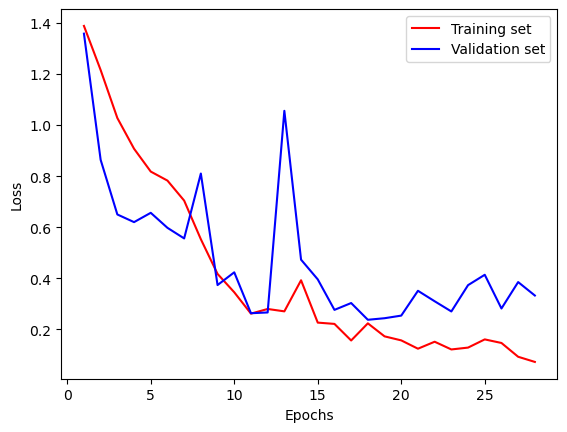

In [21]:
loss = bf.history['loss']
val_loss = bf.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label = 'Training set')
plt.plot(epochs, val_loss, 'b', label = 'Validation set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

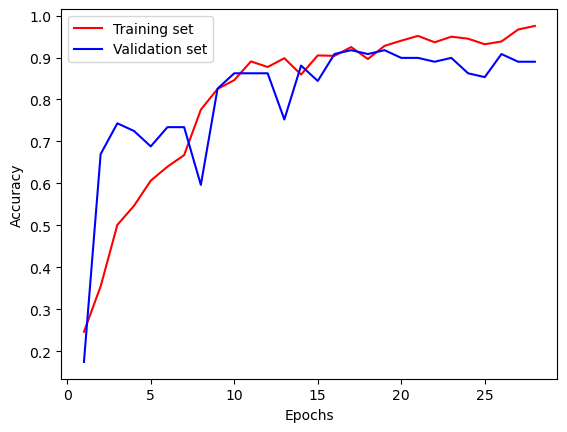

In [22]:
loss = bf.history['accuracy']
val_loss = bf.history['val_accuracy']
epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'r', label = 'Training set')
plt.plot(epochs, val_loss, 'b', label = 'Validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show

In [25]:
#model.save("nono.h5")

## function that takes any image in rgb space and pre-processes it to be ready for the cnn model

In [24]:
# function to transform image to be used in cnn
# takes an image
# returns the transformed image

def transform(og):
    t = cv2.resize(og, (64, 64))
    t = cv2.cvtColor(t, cv2.COLOR_RGB2HSV) # BGR to RGB 

    hsv_max = [179, 255, 255]

    t = np.divide(t, hsv_max)

    return t